Dataset source: https://www.kaggle.com/arashnic/hr-analytics-job-change-of-data-scientists  

In [1]:
# Library

# Basic Statistic
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import missingno

# Statistics
from scipy.stats import normaltest
from scipy.stats import chi2_contingency

# Feature Engineering
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
import category_encoders as ce

# Model Selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV,StratifiedKFold,train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, roc_auc_score, plot_roc_curve, precision_recall_curve,average_precision_score,plot_precision_recall_curve

# Imbalance Dataset
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTENC
from sklearn.utils.class_weight import compute_class_weight

# Ignore Warning
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Problem Statement

**Context**  
A company which is active in Big Data and Data Science wants to hire data scientists among people who successfully pass some courses which conduct by the company. Many people signup for their training. Company wants to know which of these candidates are really wants to work for the company after training or looking for a new employment because it helps to reduce the cost and time as well as the quality of training or planning the courses and categorization of candidates. Information related to demographics, education, experience are in hands from candidates signup and enrollment.

0 : Not looking for job change  
1 : Looking for a job change

**Problem Statement :**

Hiring process could be time and resource consuming if company targets all candidates only based on their training participation. Company wants to increase recruitment efficiency by knowing which candidates are looking for a job change in their career so they can be hired as data scientist.

**Goals :**

Company can categorized candidates who are looking and not looking for a job change so they can focus the recruitment for people who are willing to work for the company.

**Metric Evaluation**

<img src='Matrix.png'>

Type 1 error : False Positive  
Consequences: loss of recruitment cost, time and resource

Type 2 error : False Negative  
Consequences: loss of potential candidate  

Based on that consequences we want to minimize type 1 error and also type 2 error but we are interested in positive class only. So we will use F1-score 

# Data Understanding

In [2]:
#Load Dataset
df = pd.read_csv("aug_train.csv")
df

enrollee_id      city  city_development_index gender  \
0             8949  city_103                   0.920   Male   
1            29725   city_40                   0.776   Male   
2            11561   city_21                   0.624    NaN   
3            33241  city_115                   0.789    NaN   
4              666  city_162                   0.767   Male   
...            ...       ...                     ...    ...   
19153         7386  city_173                   0.878   Male   
19154        31398  city_103                   0.920   Male   
19155        24576  city_103                   0.920   Male   
19156         5756   city_65                   0.802   Male   
19157        23834   city_67                   0.855    NaN   

           relevent_experience enrolled_university education_level  \
0      Has relevent experience       no_enrollment        Graduate   
1       No relevent experience       no_enrollment        Graduate   
2       No relevent experience    Full time course        Graduate   
3       No relevent experience                 NaN        Graduate   
4      Has relevent experience       no_enrollment         Masters   
...                        ...                 ...             ...   
19153   No relevent experience       no_enrollment        Graduate   
19154  Has relevent experience       no_enrollment        Graduate   
19155  Has relevent experience       no_enrollment        Graduate   
19156  Has relevent experience       no_enrollment     High School   
19157   No relevent experience       no_enrollment  Primary School   

      major_discipline experience company_size    company_type last_new_job  \
0                 STEM        >20          NaN             NaN            1   
1                 STEM         15        50-99         Pvt Ltd           >4   
2                 STEM          5          NaN             NaN        never   
3      Business Degree         <1          NaN         Pvt Ltd        never   
4                 STEM        >20        50-99  Funded Startup            4   
...                ...        ...          ...             ...          ...   
19153       Humanities         14          NaN             NaN            1   
19154             STEM         14          NaN             NaN            4   
19155             STEM        >20        50-99         Pvt Ltd            4   
19156              NaN         <1      500-999         Pvt Ltd            2   
19157              NaN          2          NaN             NaN            1   

       training_hours  target  
0                  36     1.0  
1                  47     0.0  
2                  83     0.0  
3                  52     1.0  
4                   8     0.0  
...               ...     ...  
19153              42     1.0  
19154              52     1.0  
19155              44     0.0  
19156              97     0.0  
19157             127     0.0  

[19158 rows x 14 columns]

***
* enrollee_id : Unique ID for candidate 
* city: City code (unknown) 
* city_ development _index (CDI): Developement index of the city (scaled). Ranks cities according to their Infrastructure, Waste Management, Health, Education, and City Product
* gender: Gender of candidate 
* relevent_experience: Relevant experience of candidate 
* enrolled_university: Type of University course enrolled if any
* education_level: Education level of candidate 
* major_discipline :Education major discipline of candidate 
* experience: Candidate total experience in years
* company_size: No of employees in current employer's company 
* company_type : Type of current employer
* lastnewjob: Difference in years between previous job and current job 
* training_hours: training hours completed 
* target: Candidates who decide looking for a job change or not

In [3]:
# Count and Datatype for each Column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

This dataset have more catagorical data then numerical dataset

# Exploratory Data Analysis (EDA)

In [4]:
# Describing non Numerical Data
df.describe(include=object)

city gender      relevent_experience enrolled_university  \
count      19158  14650                    19158               18772   
unique       123      3                        2                   3   
top     city_103   Male  Has relevent experience       no_enrollment   
freq        4355  13221                    13792               13817   

       education_level major_discipline experience company_size company_type  \
count            18698            16345      19093        13220        13018   
unique               5                6         22            8            6   
top           Graduate             STEM        >20        50-99      Pvt Ltd   
freq             11598            14492       3286         3083         9817   

       last_new_job  
count         18735  
unique            6  
top               1  
freq           8040

In [5]:
# Describing Numerical Data
df.describe().drop(columns=['enrollee_id','target'])

city_development_index  training_hours
count            19158.000000    19158.000000
mean                 0.828848       65.366896
std                  0.123362       60.058462
min                  0.448000        1.000000
25%                  0.740000       23.000000
50%                  0.903000       47.000000
75%                  0.920000       88.000000
max                  0.949000      336.000000

* In `city_development_index` (CDI), the mean values is 0.828, median 0.903 and std 0.123. It means that most of the candidates are from well-developed cities.
* In `training_hours` , the mean values is 65.367, median 47 and max 336. That means there are more candidates with low training hours but some candidates spend much time to do training.

## Overall Data Value Counts

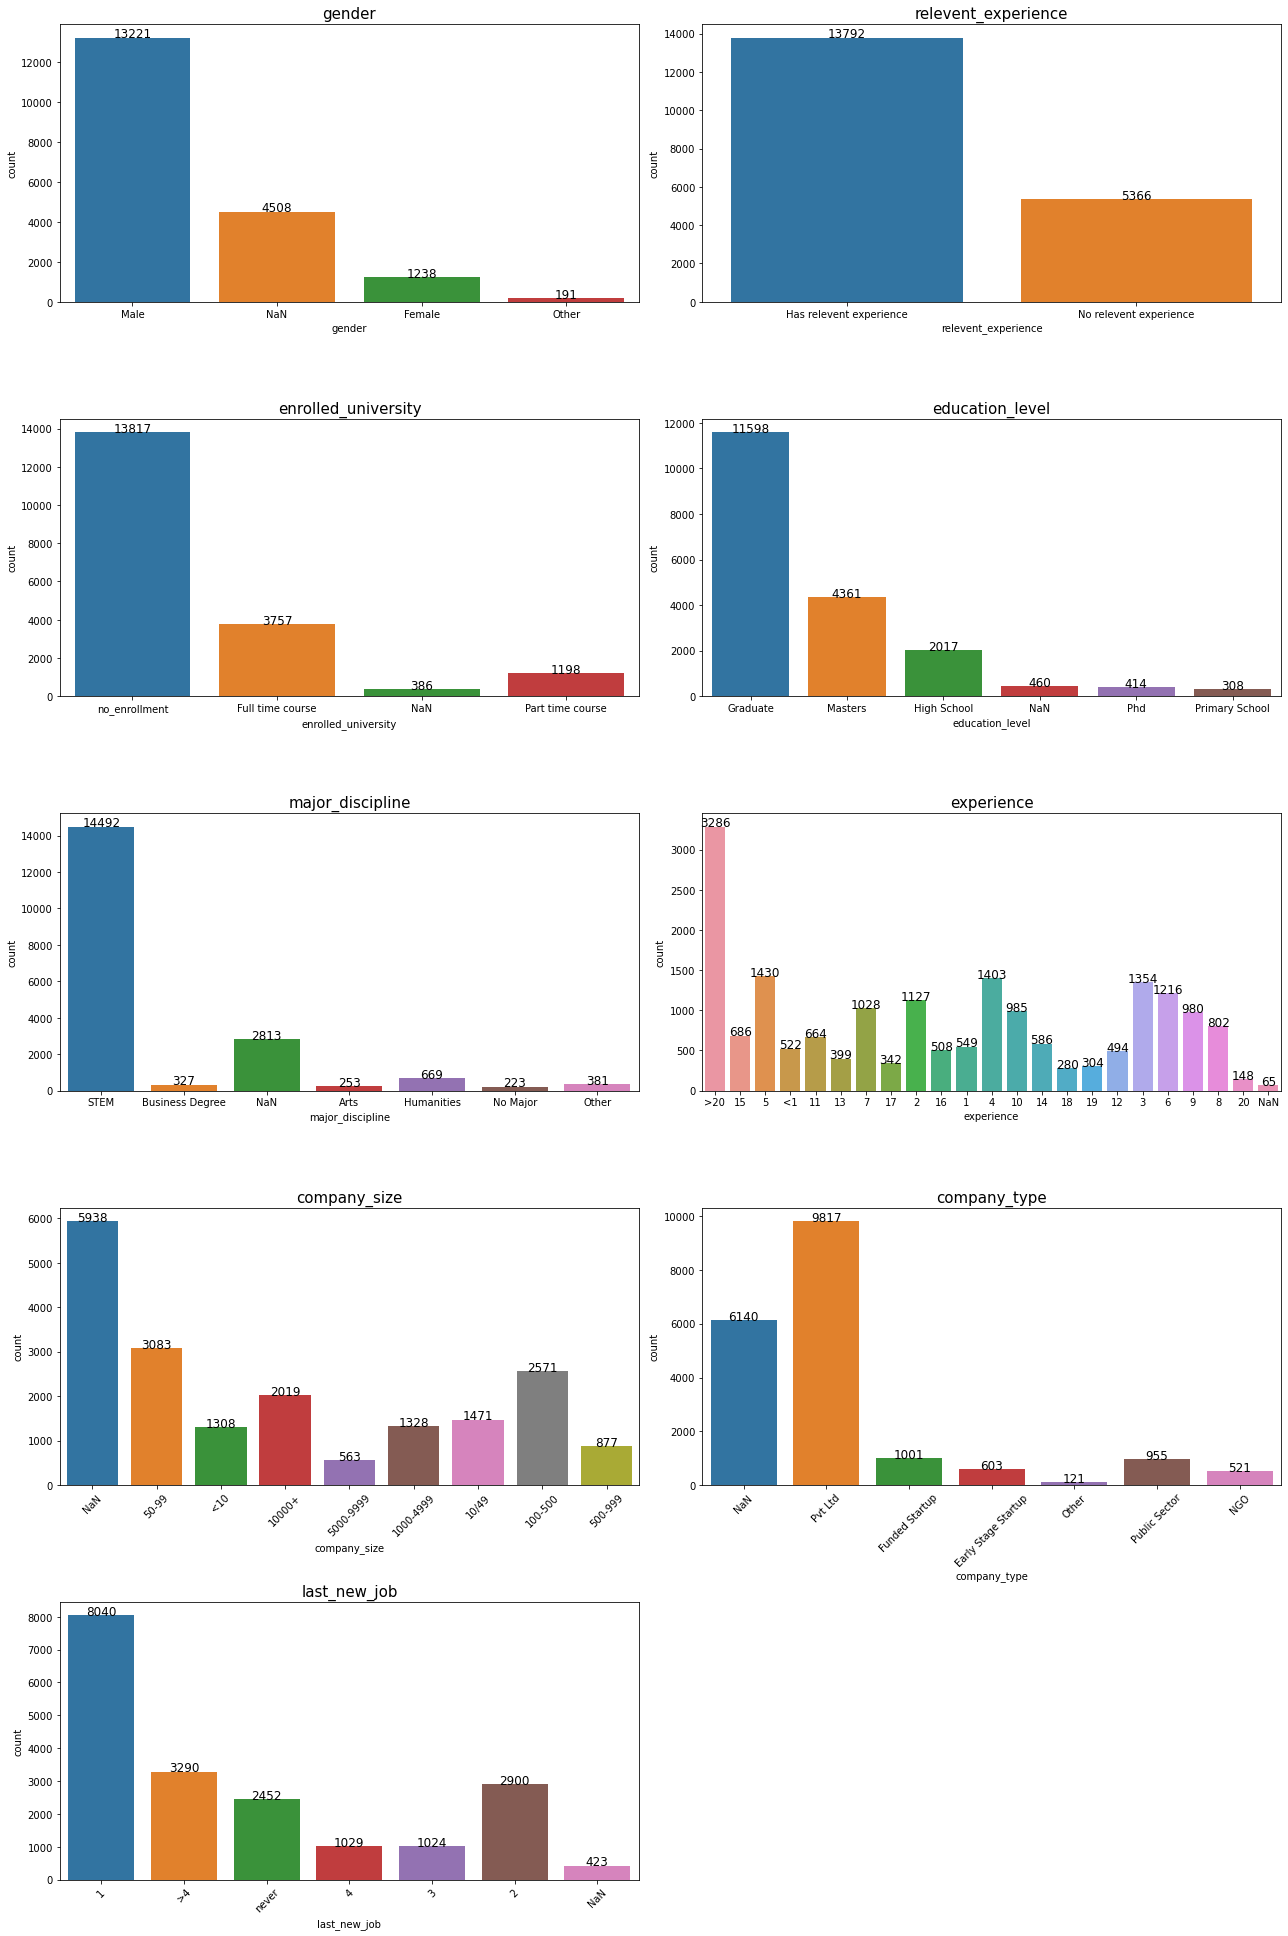

In [6]:
# Visualize data values
plt.figure(figsize=(18,27))
column_list = list(df.columns.values) [3:12]
A = 0
for i in column_list:
    A+=1
    plt.subplot(5,2,A)
    ax = sns.countplot(data=df.fillna('NaN'), x=i)
    plt.title(i, fontsize=15)
    for p in ax.patches:
        ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()), ha='center', color='black', size=12)
    if A >= 7:
        plt.xticks(rotation=45)
plt.tight_layout(h_pad=2)

## Data Distribution

<AxesSubplot:xlabel='training_hours'>

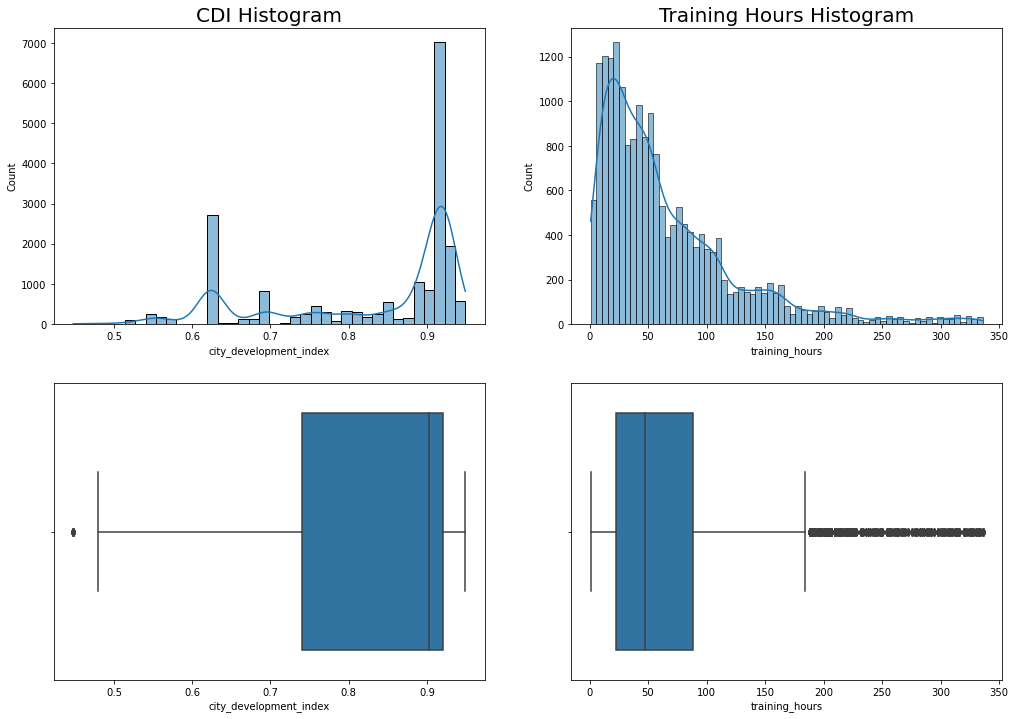

In [7]:
# Distribution of numerical data
plt.figure(figsize=(17,12))

plt.subplot(221)
sns.histplot(df['city_development_index'],kde=True)
plt.title('CDI Histogram',fontsize=20)

plt.subplot(222)
sns.histplot(df['training_hours'],kde=True)
plt.title('Training Hours Histogram',fontsize=20)

plt.subplot(223)
sns.boxplot(df['city_development_index'])

plt.subplot(224)
sns.boxplot(df['training_hours'])

In [8]:
# Distribution normality test
numerical_feature = ['city_development_index','training_hours']

for i in numerical_feature:
    stats, pval = normaltest(df[i])
    if pval > 0.05:
        print(i, ': Normal distribution')
    else:
        print(i, ': Not normal distribution')

city_development_index : Not normal distribution
training_hours : Not normal distribution


* `city_development_index` and `training_hours` data are not following normal distribution. For numerical analysis we will use non parametric method.
* `training_hours` data mostly located in left side. It is normal because people are usually excited when doing training at the beginning but stop when they feel bored. 

## Data Correlation

### Spearman Correlation

In [9]:
# Correlation of numerical data
df_numerical = df.copy()
df_numerical["experience"] = np.where(df_numerical["experience"]=="<1",1,df_numerical["experience"])
df_numerical["experience"] = np.where(df_numerical["experience"]==">20",21,df_numerical["experience"])
df_numerical["experience"] = df_numerical["experience"].astype(float)
df_numerical["last_new_job"] = np.where(df_numerical["last_new_job"]=="never",0,df_numerical["last_new_job"])
df_numerical["last_new_job"] = np.where(df_numerical["last_new_job"]==">4",5,df_numerical["last_new_job"])
df_numerical["last_new_job"] = df_numerical["last_new_job"].astype(float)
df_numerical.drop("enrollee_id",axis=1).corr("spearman")

city_development_index  experience  last_new_job  \
city_development_index                1.000000    0.300997      0.182698   
experience                            0.300997    1.000000      0.473284   
last_new_job                          0.182698    0.473284      1.000000   
training_hours                        0.007491    0.003569      0.002959   
target                               -0.279165   -0.183721     -0.082045   

                        training_hours    target  
city_development_index        0.007491 -0.279165  
experience                    0.003569 -0.183721  
last_new_job                  0.002959 -0.082045  
training_hours                1.000000 -0.014126  
target                       -0.014126  1.000000

From spearman correlation, last_new_job and experience has medium correlation (0.473), while others has weak correlation.  
To determine the predictive between features and target, we will use WOE and IV.

### Weight of Evidence (WOE) and Information Value (IV)
This dataset contains more data with catagorical type than numerical type. We will use nominal catagorical features for WOE and IV
    
    Information value, Predictive power
    < 0.02, useless for prediction
    0.02 - 0.1, weak predictor
    0.1 - 0.3, medium predictor
    0.3 - 0.5, strong predictor
    > 0.5, suspicious or too good

In [10]:
for i in df.drop(columns=['target','enrollee_id','city','city_development_index','training_hours','experience','last_new_job','company_size']).columns:
    df_woe_iv = (pd.crosstab(df[i],df['target'], normalize='columns')
                 .assign(woe=lambda dfx: np.log(dfx[1] / dfx[0]))
                 .assign(iv=lambda dfx: np.sum(dfx['woe']*(dfx[1]-dfx[0]))))
    print(df_woe_iv,'\n------------------------------------------------------------')

target      0.0       1.0       woe        iv
gender                                       
Female  0.08098  0.096222  0.172452  0.003337
Male    0.90650  0.889020 -0.019471  0.003337
Other   0.01252  0.014758  0.164458  0.003337 
------------------------------------------------------------
target                        0.0       1.0       woe        iv
relevent_experience                                            
Has relevent experience  0.753147  0.619845 -0.194790  0.083523
No relevent experience   0.246853  0.380155  0.431784  0.083523 
------------------------------------------------------------
target                    0.0       1.0       woe        iv
enrolled_university                                        
Full time course     0.164754  0.307477  0.623947  0.118886
Part time course     0.063465  0.064890  0.022210  0.118886
no_enrollment        0.771781  0.627632 -0.206746  0.118886 
------------------------------------------------------------
target                0.0   

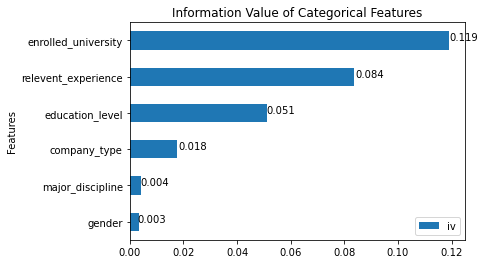

In [11]:
columns_cat = df.drop(columns=['target','enrollee_id','city','city_development_index','training_hours','experience','last_new_job','company_size']).columns
iv = []
for i in columns_cat:
    df_woe_iv = (pd.crosstab(df[i],df['target'], normalize='columns')
                 .assign(woe=lambda dfx: np.log(dfx[1] / dfx[0]))
                 .assign(iv=lambda dfx: np.sum(dfx['woe']*(dfx[1]-dfx[0]))))
    iv.append(df_woe_iv['iv'][0])

df_iv = pd.DataFrame({'Features':columns_cat,'iv':iv}).set_index('Features').sort_values(by='iv')
df_iv.plot(kind='barh', title='Information Value of Categorical Features')
for index, value in enumerate(list(round(df_iv["iv"],3))):
    plt.text((value), index,
             str(value))
plt.legend(loc="lower right")
plt.show()

* From the graph above, we can see the order of features based on its predictive power towards target.  
* Based on its IV value, `enrolled_university` is a medium predictor, `relevent_experience` and `education_level` are weak predictor, and the others are useless for prediction.

## Identify Missing Values

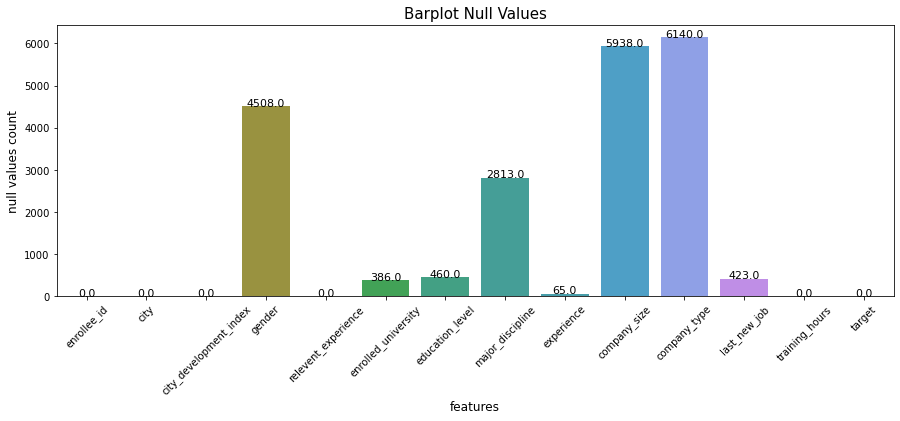

In [12]:
# Missing value percentage per column
null_df = df.isna().sum().reset_index()

ax = plt.figure(figsize=(15,5))

ax = sns.barplot(null_df['index'], null_df[0], palette='husl')
plt.xlabel('features', fontsize=12)
plt.ylabel('null values count', fontsize=12)
plt.xticks(rotation=45)
plt.title("Barplot Null Values",fontsize=15)

for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, (p.get_height())), ha='center', color='black', size=11)

plt.show()

This dataset have missing values in columns `gender`, `enrolled_university`, `education_level`, `major_discipline`, `experience`, `company_size`, `company_type`, and `last_new_job`

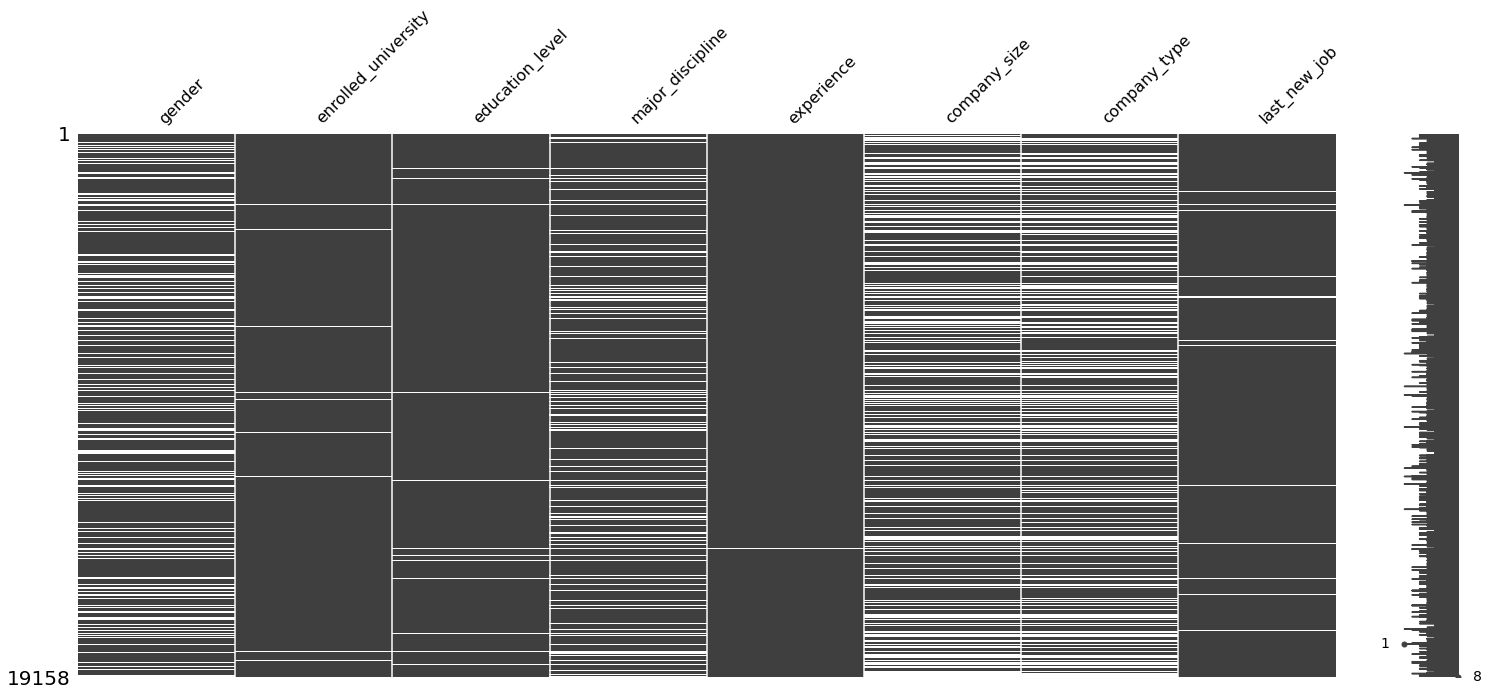

In [13]:
# Generate preview of entries with null values
df_nan = pd.DataFrame(df.isna().sum())

if df.isna().any(axis=None):
    missingno.matrix(df[df_nan[df_nan[0]>0].index])
    plt.show()

Missing values each columns have random pattern

## Identify Duplicate Data

In [14]:
# Check any duplicate data
df['enrollee_id'].duplicated().sum() #there is no duplicate data

0

## Identify Data Imbalance

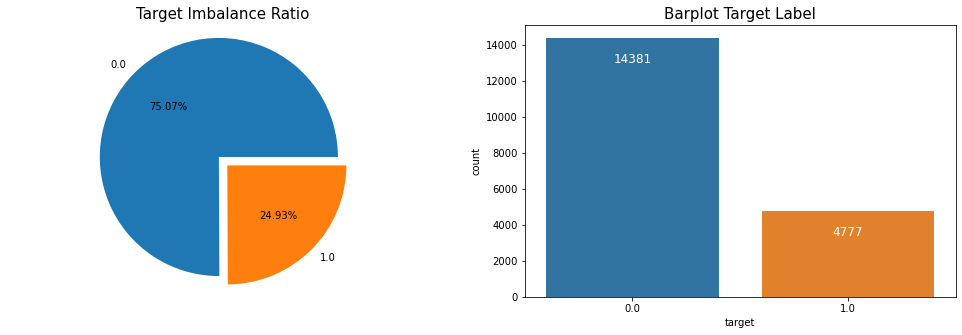

In [15]:
plt.figure(figsize=(17,(100)/20))

plt.subplot(121)
plt.pie(round(df['target'].value_counts()/len(df)*100,2),labels=list(df['target'].value_counts().index),autopct = "%.2f%%",explode = (0,0.1))
plt.axis("equal")
plt.title("Target Imbalance Ratio",size=15)

plt.subplot(122)
ax = sns.countplot(data=df, x='target')
plt.title("Barplot Target Label", fontsize=15)
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()), ha='center', va='top', color='white', size=12)

Proportion of target is imbalance

# Data Analytics

## Data propotion based on target

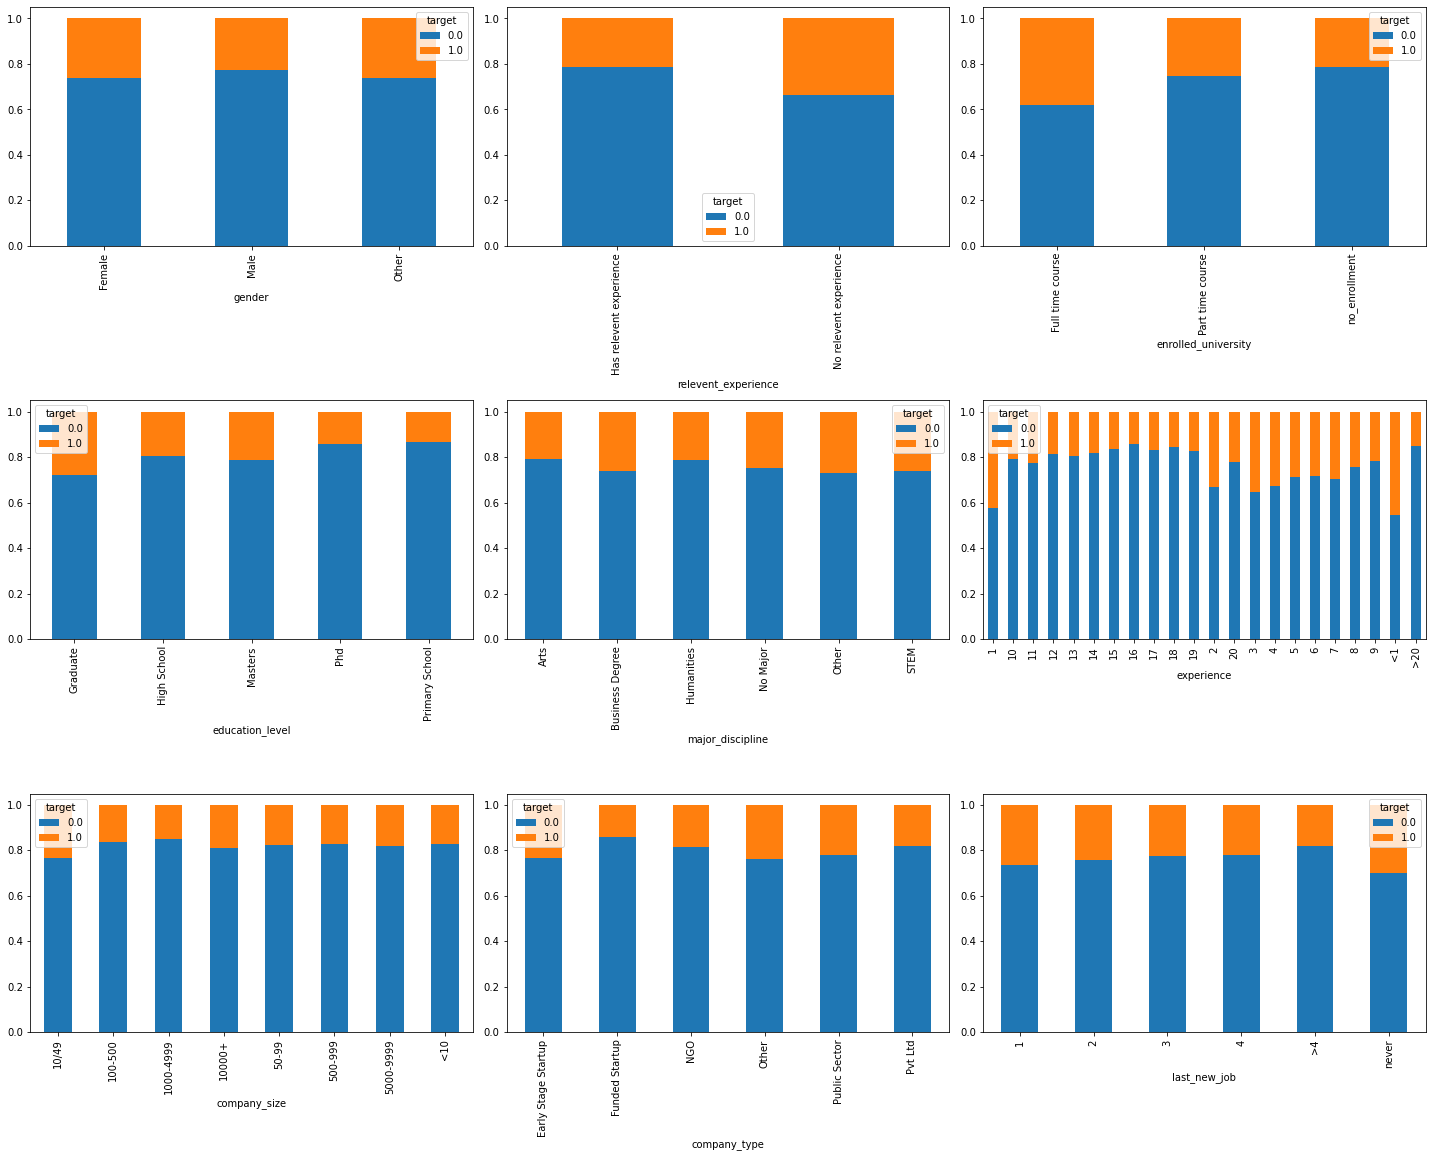

In [16]:
# Proportion of target in features
count = 0
fig = plt.figure(figsize=(20,20))

for i in df.drop(columns=['target','enrollee_id','city','city_development_index','training_hours']).columns:
      count +=1
      ax= plt.subplot(4,3,count)
      pd.crosstab(df[i],df['target'],normalize=0).plot(kind='bar',stacked=True,ax=ax)
      fig.tight_layout()

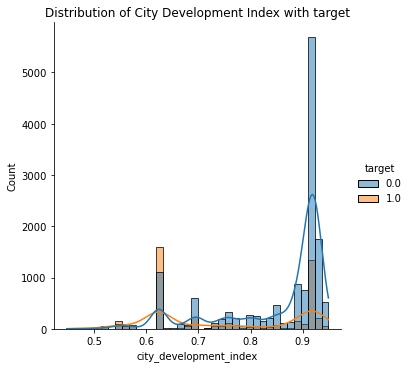

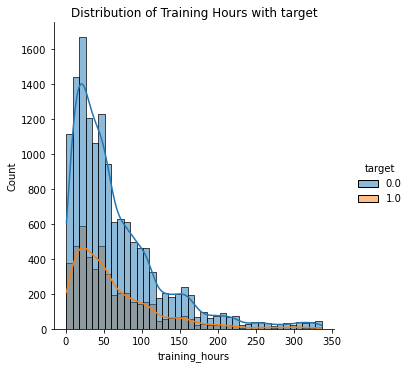

In [17]:
sns.displot(x='city_development_index',
            hue='target',
            data=df,
            stat="count",
            kde=True)
plt.title("Distribution of City Development Index with target")

sns.displot(x='training_hours',
            hue='target',
            data=df,
            stat="count",
            bins=40,
            kde=True)
plt.title("Distribution of Training Hours with target")
plt.show()

From the graph above we can see that in every feature, there is more candidates that are not looking for a job change (`target` 0) than those who are looking for a job change (`target` 1). This is aligned with the imbalance condition of `target` feature.

In [18]:
# Graphic Objects Plotly (Stacked Bar Chart)
df_target_0 = df[df['target']==0].groupby('city')['enrollee_id'].count().sort_values(ascending=False).reset_index().head(4)
df_target_1 = df[df['target']==1].groupby('city')['enrollee_id'].count().sort_values(ascending=False).reset_index().head(4)

fig=go.Figure()
#create first plot
fig.add_trace(go.Bar(x= df_target_1['city'],
                    y= df_target_1['enrollee_id'],
                    orientation='v',
                    name='Class 1',
                    hoverinfo='all'))

#create second plot
fig.add_trace(go.Bar(x= df_target_0['city'],
                    y= df_target_0['enrollee_id'],
                    orientation='v',
                    name='Class 0',
                    hoverinfo='all'))
fig.update_layout(barmode='stack', width=800, height=400, title='Top 5 Cities')
fig.show()

In [19]:
# Identify shared information between city and city_development_index
print('N unique data in city_development_index:',df['city_development_index'].nunique())
print('N unique data in city:',df['city'].nunique())

N unique data in city_development_index: 93
N unique data in city: 123


From the data exploration, we can see that:
* Top 5 `city` where the candidates come from are city_103, city_21, city_16, city_114, city_160, in which city_21 has more class 1 candidates than city_103
* All candidates that come from city 160 are class 1 candidates (looking for a job change)
* With 123 cities and 93 unique citi_development_index, we can see that there are some cities that shares same CDI value

## Independent Test with Chi-squared


Hypothesis
* Ho : There is no relation between feature and target
* Ha : There is a relation between feature and target

### Relation between feature and target

In [20]:
object_list = list(df.select_dtypes(include=object).columns)
for i in object_list:
    chisqt = pd.crosstab(df["target"], df[i], margins=True)
    value = np.array([chisqt.iloc[0],
                      chisqt.iloc[1]])
    stat,pval,dof,exp = chi2_contingency(value)
    alpha = 0.05
    if pval <= alpha:
        print(i, ": Dependent (reject H0)")
    else:
        print(i, ": Independent (H0 holds true)")

city : Dependent (reject H0)
gender : Dependent (reject H0)
relevent_experience : Dependent (reject H0)
enrolled_university : Dependent (reject H0)
education_level : Dependent (reject H0)
major_discipline : Independent (H0 holds true)
experience : Dependent (reject H0)
company_size : Dependent (reject H0)
company_type : Dependent (reject H0)
last_new_job : Dependent (reject H0)


Only `major_discipline` has no relation to target 

### Relation between feature and feature

#### Education

In [21]:
education= ['enrolled_university', 'education_level', 'major_discipline']
skip = []

for i in education:
    for x in education:
        if i == x or x in skip:
            continue
        else:
            stats, pval, dof, expected = chi2_contingency(pd.crosstab(df[i], df[x]))
            # conclusion
            if pval <= 0.05:
                print(f'Dependent (reject H0), {i} has relation with {x}')
            else:
                print(f'Independent (H0 holds true), {i} has no  relation with {x}')
    skip.append(i)

Dependent (reject H0), enrolled_university has relation with education_level
Dependent (reject H0), enrolled_university has relation with major_discipline
Dependent (reject H0), education_level has relation with major_discipline


We can use `enrolled_university`, `education_level`, `major_discipline` to fill missing values for each others

#### Company

In [22]:
company= ['company_size', 'company_type', 'enrolled_university']
skip = []

for i in company:
    for x in company:
        if i == x or x in skip:
            continue
        else:
            stats, pval, dof, expected = chi2_contingency(pd.crosstab(df[i], df[x]))
            # conclusion
            if pval <= 0.05:
                print(f'Dependent (reject H0), {i} has relation with {x}')
            else:
                print(f'Independent (H0 holds true), {i} has no  relation with {x}')
    skip.append(i)

Dependent (reject H0), company_size has relation with company_type
Dependent (reject H0), company_size has relation with enrolled_university
Dependent (reject H0), company_type has relation with enrolled_university


We can use `company_size`, `company_type`, `enrolled_university` to fill missing values for each others

#### Last New Job

In [23]:
company= ['last_new_job','experience','enrolled_university']
skip = []

for i in company:
    for x in company:
        if i == x or x in skip:
            continue
        else:
            stats, pval, dof, expected = chi2_contingency(pd.crosstab(df[i], df[x]))
            # conclusion
            if pval <= 0.05:
                print(f'Dependent (reject H0), {i} has relation with {x}')
            else:
                print(f'Independent (H0 holds true), {i} has no  relation with {x}')
    skip.append(i)

Dependent (reject H0), last_new_job has relation with experience
Dependent (reject H0), last_new_job has relation with enrolled_university
Dependent (reject H0), experience has relation with enrolled_university


We can use `last_new_job`,`enrolled_university` and `experience` to fill missing values for each others

# Preprocessing

## Fill Missing Values

### Major discipline

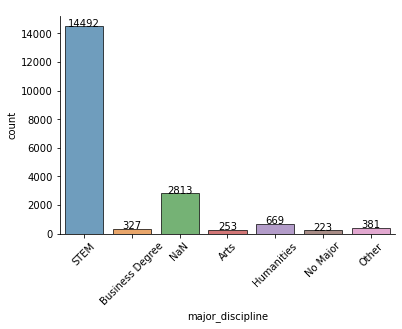

In [24]:
sns.countplot(data=df.fillna('NaN'), x='major_discipline', alpha=0.7, edgecolor='black')
sns.despine()
plt.xticks(rotation=45)
bound=ax.get_xbound()
ax=plt.gca()
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()), ha='center', color='black', size=10)
plt.show()

In [25]:
# Missing values of major discipline
print('Current missing value:', df['major_discipline'].isna().sum())
df[df['major_discipline'].isna()]['education_level'].value_counts(dropna=False)

Current missing value: 2813


High School       2017
NaN                460
Primary School     308
Graduate            22
Masters              6
Name: education_level, dtype: int64

All of candidate with `high school` and `primary school` `education_level` entry `NaN` values for `major_discipline`, thus we will fill their `major_discipline` to `NA Non Degree`

In [26]:
nan_index=(df[(df['major_discipline'].isna()) & ((df['education_level']=='High School') | (df['education_level']=='Primary School'))]).index
df['major_discipline'][nan_index]='NA Non Degree'

In [27]:
print('Current missing value:', df['major_discipline'].isna().sum())
df['major_discipline'].value_counts(dropna=False)

Current missing value: 488


STEM               14492
NA Non Degree       2325
Humanities           669
NaN                  488
Other                381
Business Degree      327
Arts                 253
No Major             223
Name: major_discipline, dtype: int64

`high school` and `primary school` graduates successfully changed to `NA Non Degree`

### Enrolled University

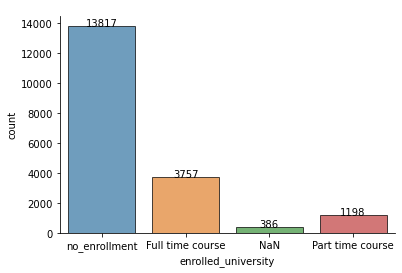

In [28]:
sns.countplot(data=df.fillna('NaN'), x='enrolled_university', alpha=0.7, edgecolor='black')
sns.despine()
plt.xticks()
bound=ax.get_xbound()
ax=plt.gca()
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()), ha='center', color='black', size=10)
plt.show()

In [29]:
df[df['enrolled_university'].isna()]['education_level'].value_counts(dropna=False)

Graduate          171
NaN               100
Masters            53
High School        47
Primary School      9
Phd                 6
Name: education_level, dtype: int64

Candidate who has `Primary School` `education_level` are not qualified to enroll university. So we will fill their `NaN` entry in `enrolled_university` to `Primary Grad`.

In [30]:
nan_index=(df[(df['enrolled_university'].isna()) & (df['education_level']=='Primary School')]).index
df['enrolled_university'][nan_index]='Primary Grad'

In [31]:
print('Current missing value:', df['enrolled_university'].isna().sum())
df[df['enrolled_university'].isna()]['education_level'].value_counts(dropna=False)

Current missing value: 377


Graduate       171
NaN            100
Masters         53
High School     47
Phd              6
Name: education_level, dtype: int64

`Primary School` candidate successfully changed to `Primary Grad`.

### Company Size/Company Type

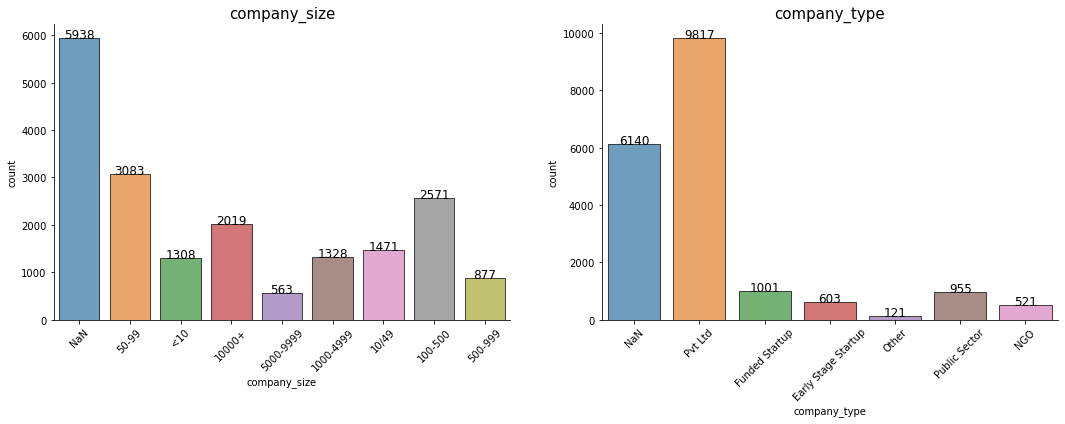

In [32]:
plt.figure(figsize=(18,25))
column_list = ['company_size','company_type']
A = 0
for i in column_list:
    A+=1
    plt.subplot(4,2,A)
    ax = sns.countplot(data=df.fillna('NaN'), x=i, alpha=0.7, edgecolor='black')
    sns.despine()
    plt.title(i, fontsize=15)
    for p in ax.patches:
        ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()), ha='center', color='black', size=12)
    if A >=0:
        plt.xticks(rotation=45)

In [33]:
df['company_size'].value_counts()

50-99        3083
100-500      2571
10000+       2019
10/49        1471
1000-4999    1328
<10          1308
500-999       877
5000-9999     563
Name: company_size, dtype: int64

In [34]:
df[(df['company_size'].isna()) & (df['company_type'].isna())]['enrolled_university'].value_counts(dropna=False)

no_enrollment       3009
Full time course    1846
Part time course     288
NaN                  208
Primary Grad           9
Name: enrolled_university, dtype: int64

Candidates enrolling `Full time course` in `enrolled_university` are not likely to work for a company. So we will set their `NaN`entry in `company_size` and `company_type` to `No Employment`.

In [35]:
nan_index=(df[(df['company_size'].isna()) & (df['company_type'].isna()) & (df['enrolled_university']=='Full time course')]).index
df['company_size'][nan_index]='No Employment'
df['company_type'][nan_index]='No Employment'

In [36]:
print('Current missing value company_size:', df['company_size'].isna().sum())
print('Current missing value company_type:', df['company_type'].isna().sum())
df[(df['company_size'].isna()) & (df['company_type'].isna())]['enrolled_university'].value_counts(dropna=False)

Current missing value company_size: 4092
Current missing value company_type: 4294


no_enrollment       3009
Part time course     288
NaN                  208
Primary Grad           9
Name: enrolled_university, dtype: int64

`Full time course` candidate successfully changed to `No Employment`.

### Last New Job

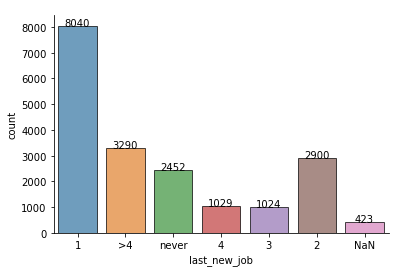

In [37]:
sns.countplot(data=df.fillna('NaN'), x='last_new_job', alpha=0.7, edgecolor='black')
sns.despine()
plt.xticks()
bound=ax.get_xbound()
ax=plt.gca()
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()), ha='center', color='black', size=10)
plt.show()

In [38]:
df[df['last_new_job'].isna()]['experience'].value_counts(dropna=False)

3      58
4      53
<1     38
2      37
5      34
>20    33
1      32
NaN    24
6      22
7      15
9      15
8      12
16      8
10      8
12      6
19      5
11      5
13      5
14      4
18      4
17      2
15      2
20      1
Name: experience, dtype: int64

Candidates having `<1` year of `experience` are not likely to have `last_new_job`. So we will fill the `NaN` values with `never`

In [39]:
df[(df['last_new_job'].isna()) & (df['experience']=='<1')]['enrolled_university'].value_counts(dropna=False)

Full time course    15
no_enrollment       15
NaN                  5
Part time course     3
Name: enrolled_university, dtype: int64

Candidates having `<1` year of `experience` and currenty `enrolled_university` at `Full time course` are not likely to have `last_new_job`. So we will fill the `NaN` values with `never`

In [40]:
nan_index=(df[(df['last_new_job'].isna()) & ((df['experience']=='<1') & (df['enrolled_university']=='Full time course'))]).index
df['last_new_job'][nan_index]='never'

In [41]:
print('Current missing value:', df['last_new_job'].isna().sum())
df[(df['last_new_job'].isna()) & (df['experience']=='<1')]['enrolled_university'].value_counts(dropna=False)

Current missing value: 408


no_enrollment       15
NaN                  5
Part time course     3
Name: enrolled_university, dtype: int64

`<1` year of `experience` and `Full time course` candidates successfully changed to `never`.

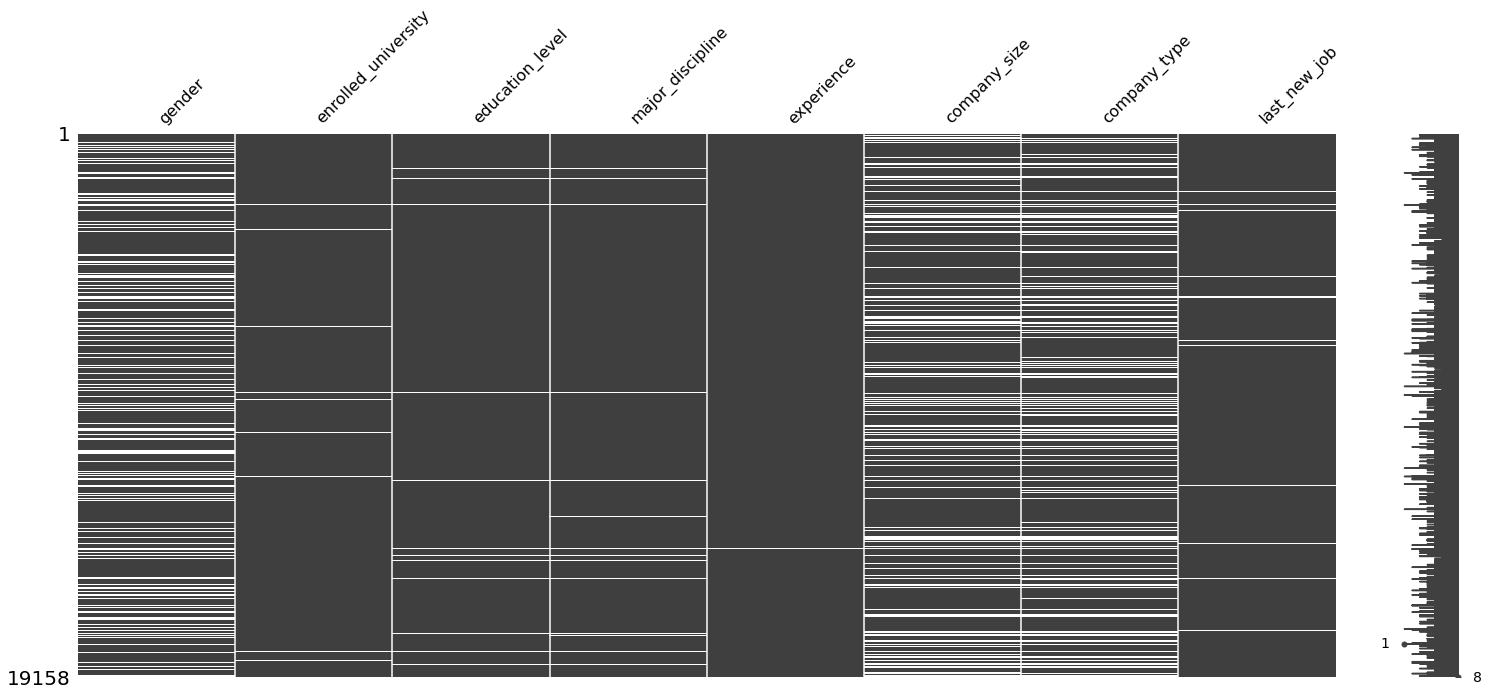

In [42]:
# Generate preview of entries with null values after NaN analysis
if df.isna().any(axis=None):
    missingno.matrix(df[df_nan[df_nan[0]>0].index])
    plt.show()

In [43]:
# Fill the rest of NaN values with simpleimputer
imputer_cons=SimpleImputer(strategy="constant",fill_value="Not Provided")
df[["education_level","company_size","company_type","enrolled_university","experience","last_new_job",'major_discipline']]=imputer_cons.fit_transform(df[["education_level","company_size","company_type","enrolled_university","experience","last_new_job",'major_discipline']])

## Data Inconsistency

In [44]:
# Make data more neat to read
df['enrolled_university'] = df['enrolled_university'].replace('no_enrollment', 'No enrollment')

In [45]:
# Correctiong punctuation
df['company_size'] = df['company_size'].replace('10/49','10-49')

## Feature Engineering

**Encoding**  
* One hot encoder : gender, company_type, major_discipline, enrolled_university
* Ordinal encoder : relevent_experience, education_level, experience, company_size, last_new_job   

In [46]:
df['company_size'].value_counts(dropna=False)

Not Provided     4092
50-99            3083
100-500          2571
10000+           2019
No Employment    1846
10-49            1471
1000-4999        1328
<10              1308
500-999           877
5000-9999         563
Name: company_size, dtype: int64

In [47]:
# Ordinal Mapping Dictionary

le = LabelEncoder()
le.fit(df['city'])

ordinal_mapping = [
    {'col':'relevent_experience',
    'mapping':{
        'Has relevent experience': 1,
        'No relevent experience': 0
    }},
    {'col':'education_level',
    'mapping':{
        'Primary School' : 0,
        'High School': 1,
        'Graduate'   : 2, 
        'Masters'    : 3, 
        'Phd'        : 4
    }},
    {'col':'experience',
    'mapping':{
        '<1'      :    0,
        '1'       :    1, 
        '2'       :    2, 
        '3'       :    3, 
        '4'       :    4, 
        '5'       :    5,
        '6'       :    6,
        '7'       :    7,
        '8'       :    8, 
        '9'       :    9, 
        '10'      :    10, 
        '11'      :    11,
        '12'      :    12,
        '13'      :    13, 
        '14'      :    14, 
        '15'      :    15, 
        '16'      :    16,
        '17'      :    17,
        '18'      :    18,
        '19'      :    19, 
        '20'      :    20, 
        '>20'     :    21
    }},
    {'col':'company_size',
    'mapping':{
        '<10'          : 0,
        '10-49'        : 1, 
        '50-99'        : 2,
        '100-500'      : 3, 
        '500-999'      : 4, 
        '1000-4999'    : 5, 
        '5000-9999'    : 6,
        '10000+'       : 7      
    }},
    {'col':'last_new_job',
    'mapping':{
        'never'        :    0,
        '1'            :    1, 
        '2'            :    2, 
        '3'            :    3, 
        '4'            :    4, 
        '>4'           :    5
    }},
    {'col':'city',
    'mapping':dict(zip(le.classes_, range(len(le.classes_))))
    }
]

In [48]:
transformer = ColumnTransformer([
    ('onehot', OneHotEncoder(), ['company_type', 'major_discipline', 'enrolled_university']),
    ('ordinal', ce.OrdinalEncoder(mapping= ordinal_mapping), ['city','relevent_experience', 'education_level', 'experience', 'company_size', 'last_new_job'])
], remainder='passthrough')

In [49]:
transformer_cat = ColumnTransformer([
    ('ordinal', ce.OrdinalEncoder(mapping= ordinal_mapping), ['city','relevent_experience', 'education_level', 'experience', 'company_size', 'last_new_job'])
], remainder='passthrough')

## Feature selection

We will use feature : 
city_development_index', 'relevent_experience', 'enrolled_university', 'education_level', 'major_discipline', 'experience', 'company_size', 'company_type', 'last_new_job', 'training_hours'  
<br> We will drop `gender` because it has low IV value and has relation with target based on statistic test. Additionaly, it can lead to discriminatory result
<br> We still keep `major_discipline` although it has no relation to target because it may contain information for other features

Target : 'target'

In [50]:
x = df.drop(columns=['enrollee_id','target','gender'])
y = df['target']

# Model Selection

We will try several models:
* Logistic Regression
* KNN 
* Decision Tree
* Random Forest
* XGBoost
* Catboost

## Splitting Data

In [51]:
x_train,x_test,y_train,y_test=train_test_split(x,y,stratify=y,test_size=.2,random_state=2020)

## Model Benchmarking

In [52]:
# Model variables
logreg = LogisticRegression(max_iter=100, random_state=2020)
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier(max_depth=3, random_state=2020)
rf = RandomForestClassifier(random_state=2020)
xgb = XGBClassifier()

# Catboost model
x_train_ord = pd.DataFrame(transformer_cat.fit_transform(x_train),columns=transformer_cat.get_feature_names())
x_test_ord = pd.DataFrame(transformer_cat.transform(x_test),columns=transformer_cat.get_feature_names())

CAT_FEATURES = ['company_type', 'major_discipline', 'enrolled_university'] 
catboost_model = CatBoostClassifier(n_estimators=100,
                                   cat_features = CAT_FEATURES,verbose=False)

In [53]:
models = [logreg,knn,dt,rf,xgb,'catboost_model']
score=[]
rata=[]
std=[]

for i in models:
    skfold=StratifiedKFold(n_splits=5)
    if i == 'catboost_model':
        model_cv=cross_val_score(catboost_model,x_train_ord,y_train,cv=skfold,scoring='f1')
    else:
        estimator=Pipeline([
            ('preprocess',transformer),
            ('model',i)])
        model_cv=cross_val_score(estimator,x_train,y_train,cv=skfold,scoring='f1')
    score.append(model_cv)
    rata.append(model_cv.mean())
    std.append(model_cv.std())
    
pd.DataFrame({'model':['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost','Catboost'],'mean':rata,'sdev':std}).set_index('model').sort_values(by='mean',ascending=False)

[17:06:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:06:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:06:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:06:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

mean      sdev
model                                  
Catboost             0.577781  0.010346
XGBoost              0.539492  0.015919
Random Forest        0.519690  0.004970
Decision Tree        0.477310  0.033435
KNN                  0.389554  0.013782
Logistic Regression  0.317814  0.012155

### Model Benchmarking: Data test

In [54]:
models = [logreg,knn,dt,rf,xgb,'catboost_model']
score_roc_auc = []
score_f1 = []

def y_pred_func(i):
    if i == 'catboost_model':
        estimator = catboost_model
        x_train2,x_test2 = x_train_ord,x_test_ord
    else:
        estimator=Pipeline([
            ('preprocess',transformer),
            ('model',i)])
        x_train2,x_test2 = x_train,x_test
    
    estimator.fit(x_train2,y_train)
    return(estimator,estimator.predict(x_test2),x_test2)

for i,j in zip(models, ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost','Catboost']):
    estimator,y_pred,x_test2 = y_pred_func(i)
    y_predict_proba = estimator.predict_proba(x_test2)[:,1]
    score_roc_auc.append(roc_auc_score(y_test,y_predict_proba))
    score_f1.append(f1_score(y_test,y_pred))
    print(j,'\n', classification_report(y_test,y_pred))
    
pd.DataFrame({'model':['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost','Catboost'],
             'roc auc score':score_roc_auc,
             'f1 score':score_f1}).set_index('model').sort_values(by='roc auc score',ascending=False)

Logistic Regression 
               precision    recall  f1-score   support

         0.0       0.78      0.93      0.85      2877
         1.0       0.52      0.23      0.32       955

    accuracy                           0.76      3832
   macro avg       0.65      0.58      0.58      3832
weighted avg       0.72      0.76      0.72      3832

KNN 
               precision    recall  f1-score   support

         0.0       0.80      0.88      0.84      2877
         1.0       0.48      0.34      0.39       955

    accuracy                           0.74      3832
   macro avg       0.64      0.61      0.62      3832
weighted avg       0.72      0.74      0.73      3832

Decision Tree 
               precision    recall  f1-score   support

         0.0       0.82      0.90      0.86      2877
         1.0       0.57      0.39      0.46       955

    accuracy                           0.78      3832
   macro avg       0.69      0.65      0.66      3832
weighted avg       0.76      0

roc auc score  f1 score
model                                       
Catboost                  0.802221  0.566667
XGBoost                   0.795259  0.558775
Random Forest             0.785159  0.509380
Decision Tree             0.777093  0.464885
Logistic Regression       0.742743  0.318016
KNN                       0.686878  0.394349

### Performance Comparison: Data train & Data test

In [55]:
def confusion_matrix_table(y_test,y_pred):
    cf = confusion_matrix(y_test, y_pred)
    group_counts = ['{0:0.0f}'.format(value) for value in
                    cf.flatten()]

    names =  ['TN', 'FP', 'FN','TP']
    perc = ["{0:.2%}".format(value) for value in
                         cf.flatten()/np.sum(cf)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2,v3 in
              zip(names, perc, group_counts)]
    labels = np.asarray(labels).reshape(2,2)
    
    return cf,labels

[17:06:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


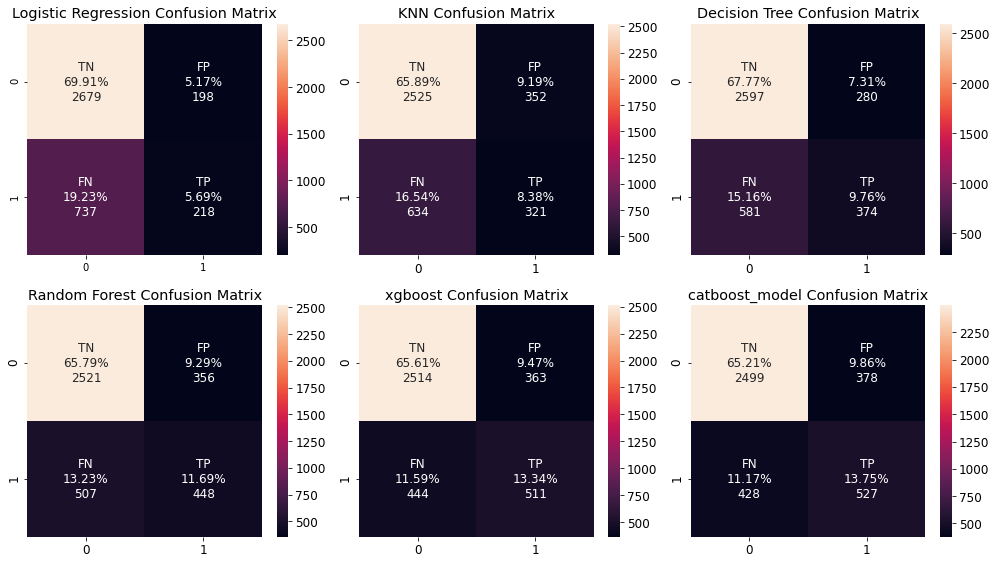

In [56]:
count = 0
models = [logreg,knn,dt,rf,xgb,'catboost_model']
fig = plt.figure(figsize=(14,8))

for i,j in zip(models,['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest','xgboost','catboost_model']):
    
    estimator,y_pred,x_test2 = y_pred_func(i)
    
    count += 1
    cf,labels = confusion_matrix_table(y_test,y_pred)
    ax= plt.subplot(2,3,count)

    plt.rcParams.update({'font.size': 12})
    sns.heatmap(cf, annot=labels, fmt='').set_title(f"{j} Confusion Matrix")
    fig.tight_layout()

In [57]:
pd.DataFrame({'model':['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest','XGBoost','Catboost'],
              'Mean Score F1 Cross Validation':rata,
             'Mean Score F1 Data Test':score_f1}).set_index('model').sort_values(by='Mean Score F1 Cross Validation',ascending=False)

Mean Score F1 Cross Validation  Mean Score F1 Data Test
model                                                                       
Catboost                                   0.577781                 0.566667
XGBoost                                    0.539492                 0.558775
Random Forest                              0.519690                 0.509380
Decision Tree                              0.477310                 0.464885
KNN                                        0.389554                 0.394349
Logistic Regression                        0.317814                 0.318016

In [58]:
y_pred = catboost_model.predict(x_test_ord)
print(f1_score(y_test,y_pred))
cr_bm = classification_report(y_test,y_pred)
print(cr_bm) 

0.5666666666666668
              precision    recall  f1-score   support

         0.0       0.85      0.87      0.86      2877
         1.0       0.58      0.55      0.57       955

    accuracy                           0.79      3832
   macro avg       0.72      0.71      0.71      3832
weighted avg       0.79      0.79      0.79      3832



Catboost gives best performances based on Data train and Data test, so we will continue using catboost model

## Imbalance data handling

### Method Benchmarking

In [59]:
cv_score = []

model_main= CatBoostClassifier(n_estimators=100,
                                   cat_features = CAT_FEATURES, 
                                   verbose=False)

classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

model_balanced = CatBoostClassifier(n_estimators=100,
                                   cat_features = CAT_FEATURES, 
                                   verbose=False,class_weights=class_weights)

def y_pred_resample(model_name):
        
    if i == 'smote':
        sm = SMOTENC(categorical_features= [True if i in CAT_FEATURES else False for i in x_train_ord.columns], random_state=0)
        x_train_res, y_train_res = sm.fit_resample(x_train_ord, y_train)
        model = model_main
    
    else:
        x_train_res, y_train_res = x_train_ord,y_train
        model = model_balanced
    
    return(x_train_res, y_train_res,model)

for i in ['smote','class weight']:
    x_train_res, y_train_res,model = y_pred_resample(i)
    skfold= StratifiedKFold(n_splits=5)
    model_cv=cross_val_score(model,x_train_res,y_train_res,cv=skfold,scoring='f1')
    cv_score.append(model_cv.mean())

In [60]:
pd.DataFrame({'model':['SMOTENC','Class Weight'],
             'cv score':cv_score}).set_index('model').sort_values(by='cv score',ascending=False)

cv score
model                 
SMOTENC       0.809462
Class Weight  0.630618

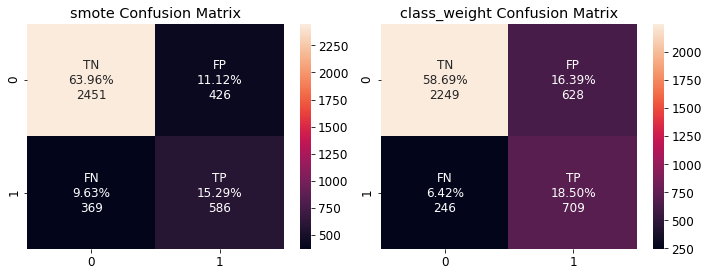

In [61]:
model_balanced = CatBoostClassifier(n_estimators=100,
                                   cat_features = CAT_FEATURES, 
                                    verbose=False,
                                   class_weights=class_weights)

imb_test_score = []
count = 0
fig = plt.figure(figsize=(10,4))

for i in ['smote','class_weight']:
    
    x_train_res, y_train_res,model = y_pred_resample(i)
    model.fit(x_train_res, y_train_res)
    
    y_pred=model.predict(x_test_ord)
    y_predict_proba = model.predict_proba(x_test_ord)[:,1]
    imb_test_score.append(f1_score(y_test,y_pred))
    
    count += 1
    cf,labels = confusion_matrix_table(y_test,y_pred)
    ax= plt.subplot(1,2,count)

    plt.rcParams.update({'font.size': 12})
    sns.heatmap(cf, annot=labels, fmt='').set_title(f"{i} Confusion Matrix")
    fig.tight_layout()


In [62]:
pd.DataFrame({'model':['SMOTE','Class Weight'],
             'cv score':cv_score,
             'f1 score':imb_test_score}).set_index('model').sort_values(by='f1 score',ascending=False)

cv score  f1 score
model                           
Class Weight  0.630618  0.618674
SMOTE         0.809462  0.595831

In [63]:
y_pred = model_balanced.predict(x_test_ord)
print(f1_score(y_test,y_pred))
cr_imb = classification_report(y_test,y_pred)

0.6186736474694591


For handling the imbalance condition, we will use class_weight because it has better performance than SMOTENC

### Before imbalance handling vs after imbalance handling 

In [64]:
pd.DataFrame({'model':['Catboost','Catboost Class Weight'],
             'f1 score':[score_f1[-1],imb_test_score[1]],
             }).set_index('model').sort_values(by='f1 score',ascending=False)

f1 score
model                          
Catboost Class Weight  0.618674
Catboost               0.566667

In [65]:
print(f'''Classification report Catboost benchmark
{cr_bm}

Classification report Catboost class_weighted
{cr_imb}
''')

Classification report Catboost benchmark
              precision    recall  f1-score   support

         0.0       0.85      0.87      0.86      2877
         1.0       0.58      0.55      0.57       955

    accuracy                           0.79      3832
   macro avg       0.72      0.71      0.71      3832
weighted avg       0.79      0.79      0.79      3832


Classification report Catboost class_weighted
              precision    recall  f1-score   support

         0.0       0.90      0.78      0.84      2877
         1.0       0.53      0.74      0.62       955

    accuracy                           0.77      3832
   macro avg       0.72      0.76      0.73      3832
weighted avg       0.81      0.77      0.78      3832




From the result we will use Catboost with balanced class weight

# Model Tunning

In [66]:
estimator = model_balanced

## Hyperparameter tunning

In [67]:
hyperparam_space={
    'depth':[3, 4, 5, 6, None],
    'loss_function': ['Logloss', 'CrossEntropy', None],
    'l2_leaf_reg':np.logspace(-20, -19, 6),
    'n_estimators':[100]
}

In [68]:
skfold=StratifiedKFold(n_splits=5)
grid_search=GridSearchCV(
    estimator,
    param_grid=hyperparam_space,
    cv=skfold,
    scoring='roc_auc',
    n_jobs=-1                                       
)

In [69]:
grid_search.fit(x_train_ord,y_train)
print(grid_search.best_score_)
print(grid_search.best_params_)

0.79942854651896
{'depth': 6, 'l2_leaf_reg': 1e-20, 'loss_function': 'Logloss', 'n_estimators': 100}


In [70]:
# Score after tunning
best_model=grid_search.best_estimator_
best_model.fit(x_train_ord, y_train)

y_pred_tunning = best_model.predict(x_test_ord)
f1_tun = f1_score(y_test,y_pred_tunning)

cr_tun = classification_report(y_test,y_pred_tunning)
print(cr_tun)
print("F1 score after tunning: ",f1_tun)

              precision    recall  f1-score   support

         0.0       0.90      0.77      0.83      2877
         1.0       0.52      0.75      0.61       955

    accuracy                           0.76      3832
   macro avg       0.71      0.76      0.72      3832
weighted avg       0.81      0.76      0.78      3832

F1 score after tunning:  0.6126970600766936


<Figure size 360x288 with 0 Axes>

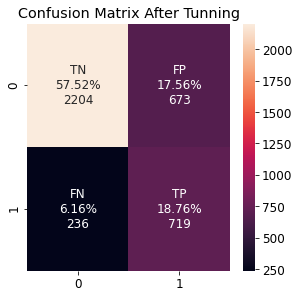

In [71]:
fig = plt.figure(figsize=(5,4))
cf,labels = confusion_matrix_table(y_test,y_pred_tunning)

plt.figure(figsize=(10,10))
ax= plt.subplot(2,2,count)
plt.rcParams.update({'font.size': 12})
sns.heatmap(cf, annot=labels, fmt='').set_title(f"Confusion Matrix After Tunning")
fig.tight_layout()

## Before tunning vs after tunning

In [72]:
pd.DataFrame({'model':['Catboost','Catboost with tunning'],
             'F1 score':[imb_test_score[1],f1_tun]
             }).set_index('model').sort_values(by='F1 score',ascending=False)

F1 score
model                          
Catboost               0.618674
Catboost with tunning  0.612697

In [73]:
print(f'''Classification report Catboost before tunning
{cr_imb}

Classification report Catboost after tunning
{cr_tun}
''')

Classification report Catboost before tunning
              precision    recall  f1-score   support

         0.0       0.90      0.78      0.84      2877
         1.0       0.53      0.74      0.62       955

    accuracy                           0.77      3832
   macro avg       0.72      0.76      0.73      3832
weighted avg       0.81      0.77      0.78      3832


Classification report Catboost after tunning
              precision    recall  f1-score   support

         0.0       0.90      0.77      0.83      2877
         1.0       0.52      0.75      0.61       955

    accuracy                           0.76      3832
   macro avg       0.71      0.76      0.72      3832
weighted avg       0.81      0.76      0.78      3832




After tunning, the overall score is not getting better than model before tunning. So, we will continue with catboost model before tunning

## Feature Importance

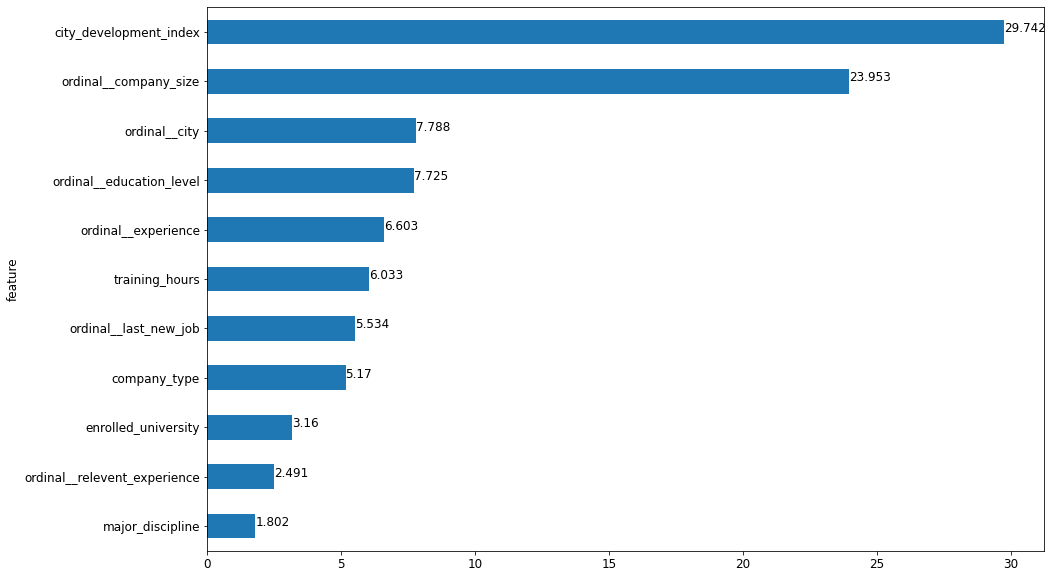

In [74]:
feature_names = x_train_ord.columns
coefs = model_balanced.feature_importances_
zipped = zip(feature_names, coefs)
df1 = pd.DataFrame(zipped, columns=["feature", "value"])
ax = df1.set_index('feature')['value'].sort_values().plot(kind='barh',figsize=(15,10))
for index, value in enumerate(round(df1.set_index('feature')['value'].sort_values(),3)):
    plt.text((value), index,
             str(value))

# Interpretable & Explainable of ML

## Shapley Value of Explanations (SHAP)

Shapley Value is a game theoretic approach to explain the output of any machine learning model. It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions. SHAP plot describes better visualization in value-level, so we can entrust more on how our feature is being important to the model

In [75]:
import shap
shap.initjs()

In [76]:
# Make new numerized df for shap
features = ['enrolled_university','major_discipline','company_type']
x_train_shap = x_train_ord.copy()
x_test_shap = x_test_ord.copy()

for i in features:
    le = LabelEncoder()
    le.fit(df[i])
    x_test_shap[i] = le.transform(x_test_ord[i])
    x_train_shap[i] = le.transform(x_train_ord[i])
    
for i in x_train_shap.select_dtypes(object).columns:
    x_train_shap[i] = pd.to_numeric(x_train_shap[i])

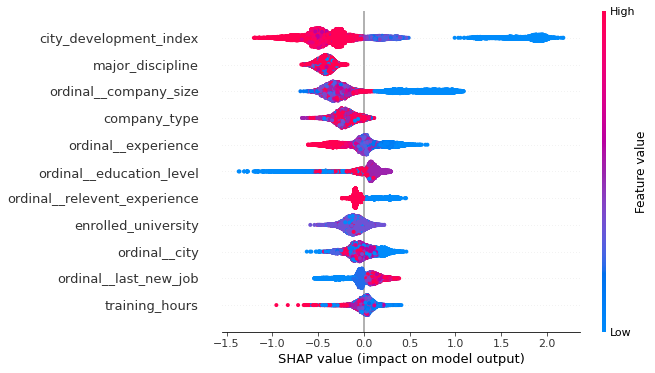

In [77]:
shap_values = shap.TreeExplainer(model_balanced,
                                feature_dependence= 'independent',
                                model_output= 'raw').shap_values(x_train_shap)
shap.summary_plot(shap_values, x_train_shap, feature_names=feature_names)

**Sidenotes:**

We know that `relevent_experience` has only 2 values, which is 0 (for No relevent experience), and 1 (for Has relevent experience boolean). SHAP Values of `relevent_experience`, which are on the right side of `X-axis = 0.0`, are blue-colored. This means that when `relevent_experience` score is = 0 (No relevent experience), so the probability of `1 (Looking for a job change)` is much higher compared to the `Has relevent experience` 

***
$\mathbf{\text{Business Insights}}$<br>
***

1.&emsp;**Domicile Factor**
<br>Candidate that comes from low `city_development_index` has higher chance to look for a new job compared to the higher one.</br>

2.&emsp;**Relevant Experience Factor**
<br>Candidate that has `No relevant experience` has higher chance to look for a new job, compared to those who `Has relevant experience`  </br>

3.&emsp;**Education Factor**
<br>Candidate that has higher `education_level` has higher chance to look for a new job, compared to those who has lower `education_level`.</br>

4.&emsp;**Experience Factor**
<br>Candidate that has lower `experience` has higher chance to look for a new job, compared to those who has higher `experience`.</br>

5.&emsp;**Last New Job Factor**
<br>Candidate that has higher  `last_new_job` has higher chance to look for a new job.</br>

In [78]:
def plot_shap(ind):
    explainer = shap.TreeExplainer(model_balanced)
    chosen_instance = x_test_ord.iloc[[ind]]
    shap_values = explainer.shap_values(chosen_instance)
    shap.force_plot(explainer.expected_value, shap_values[0], chosen_instance, matplotlib=True)

The model predict that this candidate is: looking for a job change from y_test


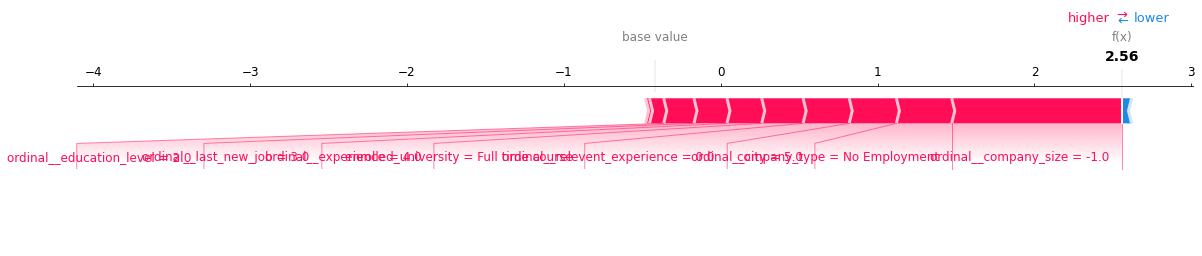

In [79]:
print(f'The model predict that this candidate is: {("looking for a job change" if y_test.iloc[np.argmax(y_predict_proba)]==1 else "not looking for a job change")} from y_test')
plot_shap(np.argmax(y_predict_proba))

The observation in which our model predict the candidate that has the highest probability to look for a job change on X-test, has `company_size  = -1 (Not Provided)`, `company_type = No Employment`,`city = 5`,`relevent_experience = 0 (no relevent experience)`,`enrolled_university = 1 (Full time course)`, `experience = 4 (3 years)`,`last_new_job = 3 (3 years)`, and `education_level = 2 (Graduate)` 

In short, this candidate is a `full-time enrolled student` and `a Graduate` who did not entry `company_size` and `company_type`, having 3 years of experience but no relevent experience, and 3 years last new job. The model predicted this candidate  is `looking for a job change` since the **output value > 0** which is **2.56**.

> Short explanation: These features (The observation in which our model predict the candidate that has the highest probability to look for a job change on X-test, has `company_size  = -1 (Not Provided)`, `company_type = No Employment`,`city = 5`,`relevent_experience = 0 (no relevent experience)`, etc) support more impact on predicting target into 1, can be seen on the red-bar graph of their contributions, compared to the blue-bar graph.

The prediction result and the real dataset shown the same result, which is `looking for a job change`. 

In [80]:
x_test_ord.iloc[np.argmax(y_predict_proba)]

ordinal__city                                  5
ordinal__relevent_experience                   0
ordinal__education_level                       2
ordinal__experience                            4
ordinal__company_size                         -1
ordinal__last_new_job                          3
city_development_index                      0.92
enrolled_university             Full time course
major_discipline                            STEM
company_type                       No Employment
training_hours                                60
Name: 173, dtype: object

The model predict that this candidate is: not looking for a job change from y_test


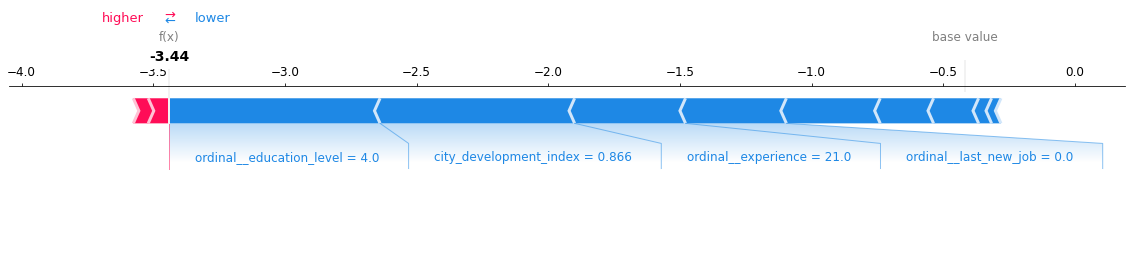

In [81]:
print(f'The model predict that this candidate is: {("looking for a job change" if y_test.iloc[np.argmin(y_predict_proba)]==1 else "not looking for a job change")} from y_test')
plot_shap(np.argmin(y_predict_proba))

The observation in which our model predict the candidate that has the lowest probability to look for a job change on X-test, has `education_level = 4 (Masters)`,`city_development_index  = 0.866`,  `experience = 21 (>20 years)`, `last_new_job = 0 (never)`.

In short, this candidate is coming from high `city_development_index`  who did not entry `company_size`, having more than 20 years of experience, and last new job is never. The model predicted this candidate  is `not looking for a job change` since the **output value < 0** which is **-3.44**.

> Short explanation: These features (`education_level = 4 (Masters)`,`city_development_index  = 0.866`,  `experience = 21 (>20 years)`, `last_new_job = 0 (never)`, etc) support more impact on predicting target into 0, can be seen on the blue-bar graph of their contributions, compared to the red-bar graph.

The prediction result and the real dataset shown the same result, which is `not looking for a job change`. 

In [82]:
x_test_ord.iloc[np.argmin(y_predict_proba)]

ordinal__city                              89
ordinal__relevent_experience                1
ordinal__education_level                    4
ordinal__experience                        21
ordinal__company_size                      -1
ordinal__last_new_job                       0
city_development_index                  0.866
enrolled_university             No enrollment
major_discipline                         STEM
company_type                     Not Provided
training_hours                            154
Name: 2861, dtype: object

## Model Prediction in Data Test 

The result example of what HR Departement will get after using this model to predict target label

In [83]:
x_test

city  city_development_index      relevent_experience  \
10477   city_16                   0.910   No relevent experience   
6388    city_21                   0.624  Has relevent experience   
6274   city_159                   0.843   No relevent experience   
15824  city_103                   0.920  Has relevent experience   
16336  city_103                   0.920   No relevent experience   
...         ...                     ...                      ...   
17022   city_67                   0.855  Has relevent experience   
3668    city_28                   0.939   No relevent experience   
2505   city_136                   0.897  Has relevent experience   
1720   city_144                   0.840  Has relevent experience   
16330   city_71                   0.884  Has relevent experience   

      enrolled_university education_level major_discipline experience  \
10477       No enrollment     High School    NA Non Degree          6   
6388         Not Provided        Graduate             STEM          3   
6274     Full time course     High School    NA Non Degree          1   
15824       No enrollment        Graduate            Other        >20   
16336       No enrollment  Primary School    NA Non Degree          3   
...                   ...             ...              ...        ...   
17022       No enrollment         Masters             STEM          6   
3668        No enrollment     High School    NA Non Degree          3   
2505        No enrollment        Graduate             STEM         15   
1720        No enrollment        Graduate             STEM         14   
16330        Not Provided    Not Provided     Not Provided        >20   

        company_size   company_type last_new_job  training_hours  
10477      5000-9999   Not Provided            1               7  
6388    Not Provided   Not Provided            1             198  
6274   No Employment  No Employment        never               6  
15824   Not Provided   Not Provided            1              68  
16336   Not Provided   Not Provided        never             198  
...              ...            ...          ...             ...  
17022          50-99        Pvt Ltd            1              42  
3668          10000+        Pvt Ltd            3              59  
2505           50-99        Pvt Ltd           >4             153  
1720           10-49        Pvt Ltd            3              52  
16330   Not Provided  Public Sector           >4              38  

[3832 rows x 11 columns]

In [84]:
# Result report
df_test = df.iloc[x_test.index][['enrollee_id']]
df_test['y_pred'] = y_pred
df_test['y_test'] = y_test
df_test = df_test.set_index('enrollee_id')
df_test[df_test['y_pred']==1]

y_pred  y_test
enrollee_id                
7757            1.0     0.0
3525            1.0     1.0
6959            1.0     0.0
30990           1.0     1.0
6965            1.0     0.0
...             ...     ...
27255           1.0     0.0
30042           1.0     0.0
29442           1.0     0.0
5662            1.0     1.0
18624           1.0     1.0

[1337 rows x 2 columns]

The table above is the resulting prediction from our model on data test. So the HR can only focus on the 905 candidates out of 3832 total candidates.

# Conclusion and Recommendation

## Conclusion

In [85]:
# Evaluation score of model machine learning used in this project sorted by process sequence
pd.DataFrame({'Model':["Logistic regression","KNN","Decision Tree","Random Forest","XGB","Catboost","Catboost SMOTENC Train","Catboost Weighted Balanced Train","Catboost SMOTENC Test","Catboost Weighted Balanced Test","Catboost Weighted Balanced Tunning"],
             'F1 score':[rata[0],rata[1],rata[2],rata[3],rata[4],rata[5],cv_score[0],cv_score[1],imb_test_score[0],imb_test_score[1],f1_tun]
             }).set_index('Model')

F1 score
Model                                       
Logistic regression                 0.317814
KNN                                 0.389554
Decision Tree                       0.477310
Random Forest                       0.519690
XGB                                 0.539492
Catboost                            0.577781
Catboost SMOTENC Train              0.809462
Catboost Weighted Balanced Train    0.630618
Catboost SMOTENC Test               0.595831
Catboost Weighted Balanced Test     0.618674
Catboost Weighted Balanced Tunning  0.612697

In [86]:
# Classification report of final model
print(cr_imb)

              precision    recall  f1-score   support

         0.0       0.90      0.78      0.84      2877
         1.0       0.53      0.74      0.62       955

    accuracy                           0.77      3832
   macro avg       0.72      0.76      0.73      3832
weighted avg       0.81      0.77      0.78      3832



<p style='text-align: justify;'> Dataset contains information about people who completed training and the label of people who are looking for a job change or not.  
We tried 5 models and got the result with high marks (strong learner) which are Catboost, Xgboost, Random forest, KNN, and Logistic regression. Since the dataset contains more catagorical than numerical features, Catboost got the best performance then other models because it is very good to handle catagorical features. So, we continued to use Catboost for the next step.
    
This dataset has imbalance label data with the number of label 0 is 3 times more than label 1. To handle it, we compared 2 methods, which are SMOTENC and balanced class weight. The result is balanced class weight gives better performance than SMOTENC because SMOTENC gives overfitting result. It can happen because SMOTENC replicate the data and it will get good result only in training set.  
    
To optimize the model, we did hyperparameter tunning using grid search and found default model gave better performance than model after tunning. Another advantages of Catboost is that it can get best result only using default parameters. To make our model is explainable and interpretable, we used SHAP method. With SHAP, we can answer the problem to help HR Departments to reach their goals as mentioned in the problem statement. </p>

The characteristics of candidates who are looking for a job change have following features :

1.&emsp;**Domicile Factor**
<br>Candidate that comes from low `city_development_index` has higher chance to look for a new job compared to the higher one.</br>

2.&emsp;**Relevant Experience Factor**
<br>Candidate that has `No relevant experience` has higher chance to look for a new job, compared to those who `Has relevant experience`  </br>

3.&emsp;**Education Factor**
<br>Candidate that has higher `education_level` has higher chance to look for a new job, compared to those who has lower `education_level`.</br>

4.&emsp;**Experience Factor**
<br>Candidate that has lower `experience` has higher chance to look for a new job, compared to those who has higher `experience`.</br>

5.&emsp;**Last New Job Factor**
<br>Candidate that has higher  `last_new_job` has higher chance to look for a new job.</br>

From that result, HR can focusing their offer to candidates who are predicted as looking for a job change, rather than targeting all candidates, which can save time and cost for recruitment.

## Recommendation

* HR Departments
    - HR can focus to offer the job for candidates who live in city_160 because all candidates from this city is looking for a new job and city_21 because the proportion of candidates who looking for a job is higher than candidates who not looking for a job change
    - HR can develop data collecting method to get another features for analyzed and better data quality to help data scientist make a better prediction model
    - HR can look for the candidates who come from cities with lower city development index, have no relevent experience, higher education level, lower job experience, and higher last new job to get higher chance of candidates that are looking for a job.
    - HR can make the training more compact because a lot of people don't spend much time to complete the training.

# References

WOE & IV
* https://towardsdatascience.com/model-or-do-you-mean-weight-of-evidence-woe-and-information-value-iv-331499f6fc2#:~:text=Specifically%2C%20when%20it%20comes%20to%20classification%20problems%2C%20WoE,which%20is%20based%20on%20them%20defaulting%20credit%20repayment.

SMOTENC  
* https://medium.com/@cmukesh8688/how-to-handle-imbalanced-classification-problems-4a96f42ae4c4  

CATBOOST MODEL  
* https://catboost.ai/docs/concepts/python-reference_catboostclassifier.html
